In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
dev_name = 'HCI'
pg_path = '/content/drive/MyDrive/CodeData/[Packages]'+dev_name
sys.path.append(pg_path)

Mounted at /content/drive


In [3]:
import numpy as np
import scipy.io

m = scipy.io.loadmat('/content/drive/MyDrive/CodeData/HCI/data/BCICIV_calib_ds1d.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_name = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

print('shape of EEG:', EEG.shape)
print('sample rate:', sample_rate)
print('number of channels:', nchannels)
print('channel names:', channel_name)
print('number of event:', len(event_onsets))
print('event codes:', np.unique(event_codes))
print('class labels:', cl_lab)
print('number of classes:', nclasses)

shape of EEG: (59, 190473)
sample rate: 100
number of channels: 59
channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
number of event: 1
event codes: [-1  1]
class labels: ['left', 'right']
number of classes: 2


In [4]:
trials = {}
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
  cl_onsets = event_onsets[event_codes==code]
  trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

  for i, onset in enumerate(cl_onsets):
    trials[cl][:,:,i] = EEG[:, win+onset]

print('shape of trials[cl1]:', trials[cl1].shape)
print('shape of trials[cl2]:', trials[cl2].shape)

shape of trials[cl1]: (59, 200, 100)
shape of trials[cl2]: (59, 200, 100)


In [5]:
from matplotlib import mlab

def psd(trials):
  ntrials = trials.shape[2]
  trials_PSD = np.zeros((nchannels, 101, ntrials))

  for trial in range(ntrials):
    for ch in range(nchannels):
      (PSD, freqs)= mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
      trials_PSD[ch,:,trial] = PSD.ravel()

  return trials_PSD, freqs


In [6]:
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1:psd_r, cl2:psd_f}

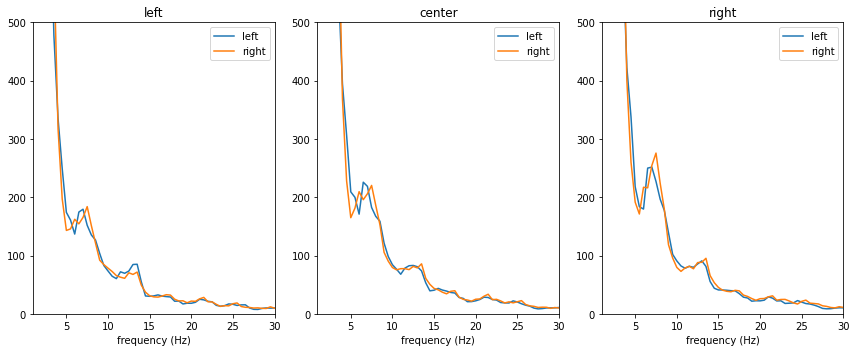

In [7]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
  plt.figure(figsize=(12, 5))
  nchans = len(chan_ind)

  nrows = int(np.ceil(nchans/3))
  ncols = min(3, nchans)

  for i, ch in enumerate(chan_ind):
    plt.subplot(nrows,ncols, i+1)

    for cl in trials.keys():
      plt.plot(freqs, np.mean(trials_PSD[cl][ch, :, :], axis=1), label=cl)

      plt.xlim(1, 30)
      if maxy != None:
        plt.ylim(0, maxy)

      plt.grid()
      plt.xlabel('frequency (Hz)')
      if chan_lab == None:
        plt.title('channel %d'%(ch+1))
      else: 
        plt.title(chan_lab[i])

      plt.legend()

  plt.tight_layout()

plot_psd(trials_PSD, freqs, [channel_name.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=500)

In [8]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
  a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

  ntrials = trials.shape[2]
  trials_filt = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
  return trials_filt

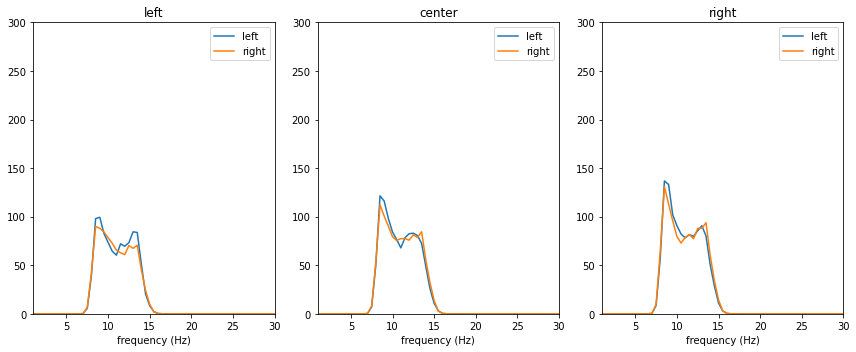

In [9]:
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate), cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2:psd_f}

plot_psd(trials_PSD, freqs, [channel_name.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=300)

In [10]:
def logvar(trials):
  return np.log(np.var(trials, axis=1))

trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

def plot_logvar(trials):
  plt.figure(figsize=(12,5))

  x0 = np.arange(nchannels)
  x1 = np.arange(nchannels)+0.4
  y0 = np.mean(trials[cl1], axis=1)
  y1 = np.mean(trials[cl2], axis=1)
  plt.bar(x0, y0, width=0.5, color='b')
  plt.bar(x1, y1, width=0.4, color='r')

  plt.xlim(-0.5, nchannels+0.5)

  plt.gca().yaxis.grid(True)
  plt.title('log-var of each channel/component')
  plt.xlabel('channels/components')
  plt.ylabel('log-var')
  plt.legend(cl_lab)


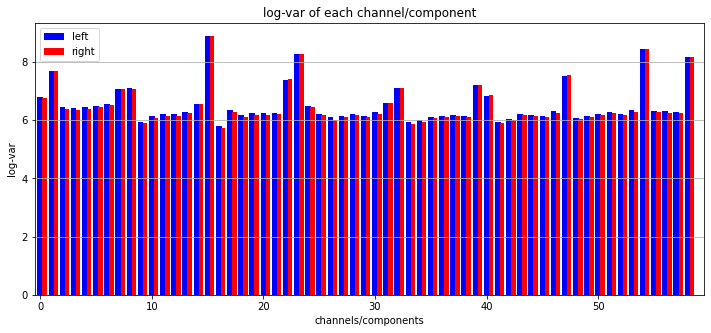

In [11]:
plot_logvar(trials_logvar)

In [12]:
from numpy import linalg

def cov(trials):
  ntrials = trials.shape[2]
  covs = [trials[:,:,i].dot(trials[:,:,i].T)/nsamples for i in range(ntrials)]
  return np.mean(covs, axis=0)

def whitening(sigma):
  U, I, _ = linalg.svd(sigma)
  return U.dot(np.diag(I**-0.5))

def csp(trials_r, trials_f):
  cov_r = cov(trials_r)
  cov_f = cov(trials_f)
  P = whitening(cov_r+cov_f)
  B, _, _ = linalg.svd(P.T.dot(cov_f).dot(P))
  W = P.dot(B)
  return W

def apply_mix(W, trials):
  ntrials = trials.shape[2]
  trials_csp = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
  return trials_csp

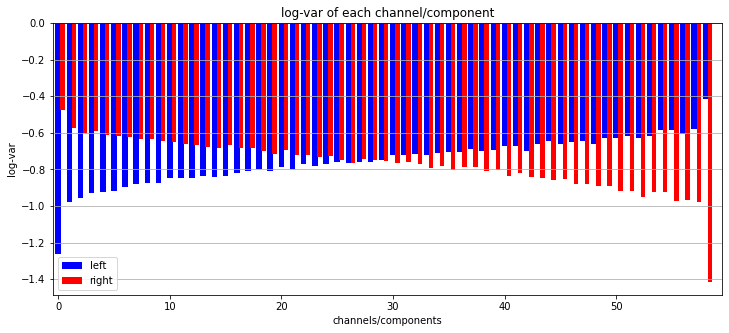

In [13]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1:apply_mix(W, trials_filt[cl1]), cl2:apply_mix(W, trials_filt[cl2])}
                            
trials_logvar = {cl1:logvar(trials_csp[cl1]), cl2:logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

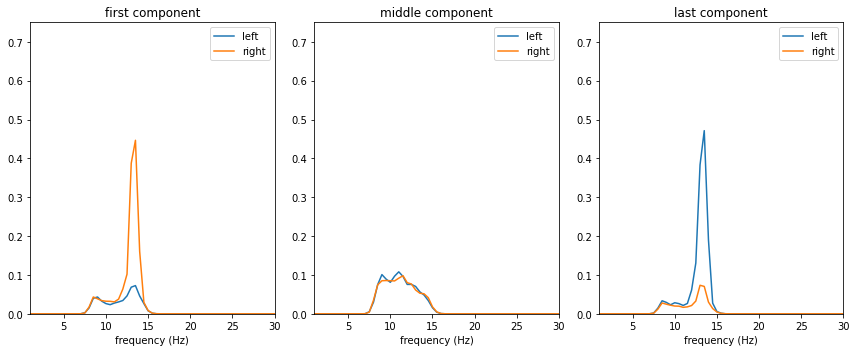

In [14]:
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])

trials_PSD = {cl1: psd_r, cl2:psd_f}

plot_psd(trials_PSD, freqs, [0, 28, -1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75)


In [15]:
def plot_scatter(left, foot):
  plt.figure()
  plt.scatter(left[0,:], left[-1,:], color='b')
  plt.scatter(foot[0,:], foot[-1,:], color='r')
  plt.xlabel('last component')
  plt.ylabel('first component')
  plt.legend(cl_lab)

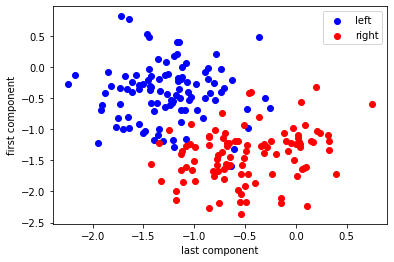

In [16]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

[[0.87459513 0.73644253]
 [0.73644253 1.69330068]]
[[ 1.01079108  4.12053948]
 [ 4.12053948 18.00913162]]


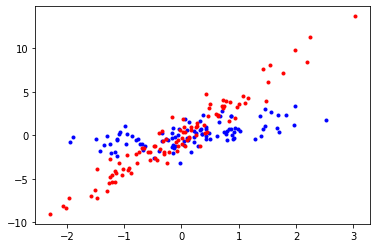

In [17]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

n = 100
x1 = np.empty((n,2))
x1[:,0] = np.random.randn(n)
x1[:,1] = x1[:,0] + np.random.randn(n)

x2 = np.empty((n,2))
x2[:,0] = np.random.randn(n)
x2[:,1] = 4 * x2[:,0] + np.random.randn(n)

cov_x1 = np.cov(x1.T)
cov_x2 = np.cov(x2.T)

print(cov_x1)
print(cov_x2)

fig, ax = plt.subplots()
ax.plot(x1[:,0], x1[:,1], 'b.')
ax.plot(x2[:,0], x2[:,1], 'r.')



[0.441382  2.1265138]
[[-0.86192826 -0.50703024]
 [ 0.50703024 -0.86192826]]
[ 0.06460583 18.95531687]
[[-0.97463463 -0.22380198]
 [ 0.22380198 -0.97463463]]


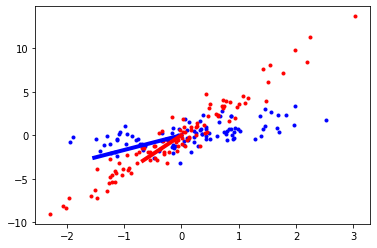

In [18]:
d1, v1 = np.linalg.eig(cov_x1)
d2, v2 = np.linalg.eig(cov_x2)
print(d1)
print(v1)
print(d2)
print(v2)

x1_v = np.empty((2, 2))
x1_v[0,0] = 0
x1_v[0,1] = 0
x1_v[1,0] = v1[0,1] * 3
x1_v[1,1] = v1[1,1] * 3

x2_v = np.empty((2, 2))
x2_v[0,0] = 0
x2_v[0,1] = 0
x2_v[1,0] = v2[0,1] * 3
x2_v[1,1] = v2[1,1] * 3

fig, ax = plt.subplots()
ax.plot(x1[:,0], x1[:,1], 'b.')
ax.plot(x2[:,0], x2[:,1], 'r.')
ax.plot(x1_v[:,0], x1_v[:,1], 'b', linewidth=4)
ax.plot(x2_v[:,0], x2_v[:,1], 'r', linewidth=4)

[9.22029381+0.j 0.0831257 +0.j]
[[ 0.97525778  0.4459756 ]
 [-0.22107073 -0.89504512]]


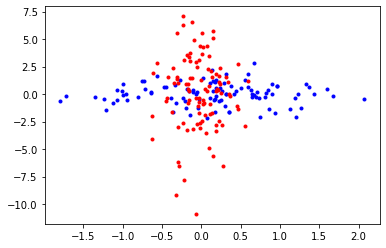

In [19]:
csp_d, csp1= linalg.eig(cov_x1, cov_x2)
print(csp_d)
print(csp1)

csp_x1 = x1.dot(csp1)
csp_x2 = x2.dot(csp1)

fig, bx = plt.subplots()
bx.plot(csp_x1[:,0], csp_x1[:,1], 'b.')
bx.plot(csp_x2[:,0], csp_x2[:,1], 'r.')

In [20]:
train_percentage = 0.5
ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_r
ntest_f = trials_filt[cl2].shape[2] - ntrain_f
train = {cl1: trials_filt[cl1][:,:,:ntrain_r], 
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_r:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

      
W = csp(train[cl1], train[cl2])

train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

comp = np.array([0, -1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [21]:
def train_lda(class1, class2):
  nclasses = 2
  nclass1 = class1.shape[0]
  nclass2 = class2.shape[0]

  prior1 = nclass1 / float(nclass1 + nclass2)
  prior2 = nclass2 / float(nclass1 + nclass1)

  mean1 = np.mean(class1, axis=0)
  mean2 = np.mean(class2, axis=0)
  
  class1_centered = class1 - mean1
  class2_centered = class2 - mean2
  
  cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
  cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)

  W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
  b = (prior1*mean1 + prior2*mean2).dot(W)

  return (W, b)

def apply_lda(test, W, b):
  ntrials = test.shape[1]

  prediction = []

  for i in range(ntrials):
    result = W.dot(test[:,i]) - b
    if result <= 0:
      prediction.append(1)
    else:
      prediction.append(2)

  return np.array(prediction)

In [22]:
W, b = train_lda(train[cl1].T, train[cl2].T)

print('W: ', W)
print('b: ', b)

W:  [ 5.31347949 -5.52963938]
b:  0.3802472103808654


(-2.2, 1.0)

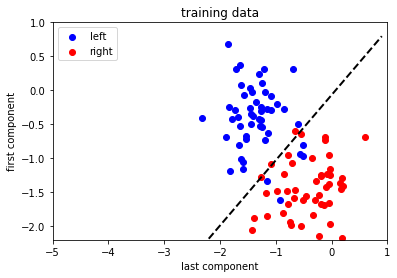

In [23]:
plot_scatter(train[cl1], train[cl2])
title('training data')

#calculate decision boundary(x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

#plot the decision boundary
plt.plot(x, y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

(-2.2, 1.0)

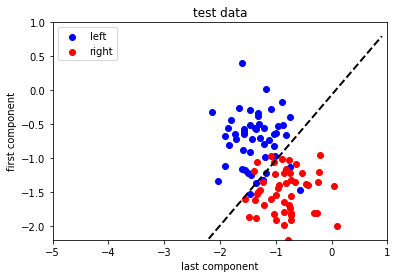

In [24]:
plot_scatter(test[cl1], test[cl2])
title('test data')

#plot the decision boundary
plt.plot(x, y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

In [25]:
#print confusion matrix
conf = np.array([
    [(apply_lda(test[cl1], W, b)==1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()], 
    [(apply_lda(test[cl1], W, b)==2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()]
])

print('confusion matrix:')
print(conf)
print()
print('accurancy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

confusion matrix:
[[45  4]
 [ 5 46]]

accurancy: 0.910


In [26]:
#LDA with scikit-learn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.array([[-1,-1], [-2,-1], [-3,-2], [1,1], [2,1], [3,2]])
y = np.array([1, 1, 1, 2, 2, 2])

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

print(clf.predict([[-0.8, -1]]))

[1]
